In [1]:
from sklearn.preprocessing import MinMaxScaler
from tsfresh import select_features
from tsfresh.feature_extraction import extract_features
import keras
from tensorflow.keras import layers
from tensorflow import keras
import pandas as pd
from tqdm import tqdm
import sys
sys.path.append('..')
from lib.download import *
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import explained_variance_score

usdt_tickers = get_pair_tickers()
data = pd.read_pickle(f'data/usdt_data_features/{usdt_tickers[1]}.pickle').astype(float)
data = data.dropna()
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

#ajouter train test

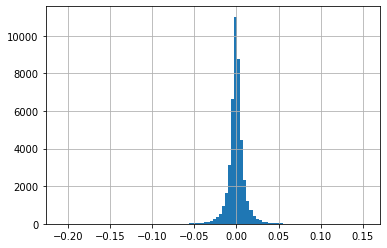

In [18]:
data['close'].pct_change().hist(bins=100);

In [3]:
import concurrent.futures
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from tqdm import tqdm
import numpy as np

def compute_silhouette_score(n_clusters, returns):
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    kmeans.fit(returns)
    return silhouette_score(returns, kmeans.predict(returns))

silhouette_scores = []
returns = np.array(data['close'].pct_change().dropna()).reshape(-1,1)
cluster_sizes = [x*3 for x in range(1,10)]

silh = [compute_silhouette_score(n_clusters, returns) for n_clusters in tqdm(cluster_sizes)]

100%|██████████| 9/9 [03:41<00:00, 24.59s/it]


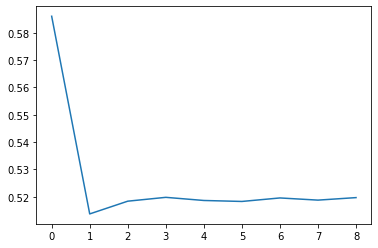

In [4]:
plt.plot(silh)

In [27]:
rets_df = data['close'].pct_change().dropna().reset_index(drop=True)
kmeans = KMeans(n_clusters=6, random_state=0)
kmeans.fit(returns)
classes = pd.DataFrame(kmeans.predict(returns))
classes.value_counts()

0    17905
4    15918
2     5064
1     3861
3      641
5      499
dtype: int64

In [ ]:
#fonction a maximiser => rentabilité cumulée(voir projet paris sportifs)
#nombre de clusters a reglers selon les perfs du machine learning
donner classements au cluster

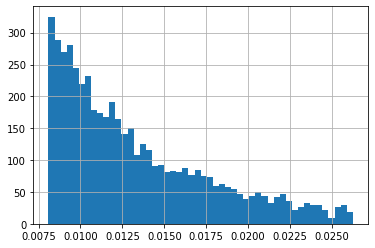

In [30]:
rets_df[classes[0]==2].hist(bins=50);

In [32]:
def sampling(args):
    z_mean, z_log_var = args
    batch = keras.backend.shape(z_mean)[0]
    dim = keras.backend.int_shape(z_mean)[1]
    epsilon = keras.backend.random_normal(shape=(batch, dim))
    return z_mean + keras.backend.exp(0.5 * z_log_var) * epsilon

def train_vae(latent_dim, train_data, test_data):
    encoder_inputs = keras.Input(shape=(train_data.shape[1],))
    x = layers.Dense(256, activation="relu")(encoder_inputs)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dense(64, activation="relu")(x)
    z_mean = layers.Dense(latent_dim)(x)
    z_log_var = layers.Dense(latent_dim)(x)

    encoder = keras.Model(encoder_inputs, [z_mean, z_log_var], name="encoder")

    latent_inputs = keras.Input(shape=(latent_dim,))
    x = layers.Dense(64, activation="relu")(latent_inputs)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dense(256, activation="relu")(x)
    decoder_outputs = layers.Dense(train_data.shape[1])(x)

    decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")

    encoder_outputs = encoder(encoder_inputs)
    latent_outputs = encoder_outputs[0]
    latent_outputs = keras.layers.Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])
    decoder_outputs = decoder(latent_outputs)

    vae = keras.Model(encoder_inputs, decoder_outputs, name="vae")

    vae.compile(optimizer="adam", loss="mse")
    history = vae.fit(train_data, train_data, epochs=100, batch_size=64, validation_data=(test_data, test_data), verbose=1)
    last_10_epochs_loss = history.history['val_loss'][-10:]
    mean_loss = np.mean(last_10_epochs_loss)
    return mean_loss, encoder, history

In [3]:
import concurrent.futures
import numpy as np

latent_dims = [x * 3 for x in range(5, 20)]
losss = []

def train_and_append_loss(latent_dim):
    mean_loss, encoder, history = train_vae(latent_dim, train_data, test_data)
    losss.append([mean_loss, latent_dim])

with concurrent.futures.ThreadPoolExecutor() as executor:
    futures = [executor.submit(train_and_append_loss, latent_dim) for latent_dim in latent_dims]
    for f in tqdm(concurrent.futures.as_completed(futures), total=len(latent_dims)):
        pass

  0%|          | 0/15 [00:00<?, ?it/s]

100%|██████████| 15/15 [27:33<00:00, 110.20s/it]  


In [4]:
losss

[[0.16503725945949554, 27],
 [0.1576167181134224, 39],
 [0.16730373352766037, 30],
 [0.15401120185852052, 48],
 [0.23872399032115937, 18],
 [0.13724899739027024, 45],
 [0.1458254337310791, 33],
 [0.20190445631742476, 21],
 [0.26538967192173, 15],
 [0.1712586134672165, 54],
 [0.20173754543066025, 24],
 [0.14236289858818055, 42],
 [0.14197547733783722, 51],
 [0.14771448820829391, 57],
 [0.19143985509872435, 36]]

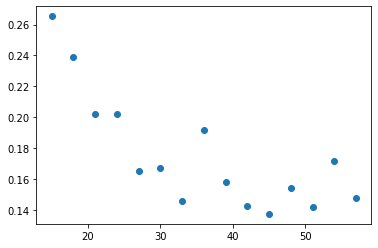

In [5]:
import matplotlib.pyplot as plt
plt.scatter(np.array(losss).T[1], np.array(losss).T[0])

In [33]:
mean_loss, encore, history = train_vae(45, train_data, test_data)

NameError: name 'train_data' is not defined

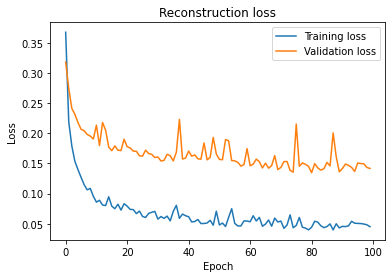

In [9]:
import matplotlib.pyplot as plt
# Plot the reconstruction loss
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Reconstruction loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [10]:
features_train = encore.predict(train_data)
features_test = encore.predict(test_data)
features = pd.concat([pd.DataFrame(features_train[0]), pd.DataFrame(features_test[0])],axis=0, ignore_index=True)
features.index = data.index
features.tail()

275/275 [==============================] - 0s 1ms/step


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41
timestamp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2023-01-30 14:00:00,-0.643941,0.641748,-1.060324,-0.770454,-0.477600,-2.138387,1.119661,-1.329886,0.507452,-0.209743,1.900491,0.038663,0.769183,-0.082229,-1.704337,1.298404,-0.066480,1.955322,0.951770,-1.847294,1.668406,1.349381,1.495830,-1.002453,0.052329,-2.680240,-0.693954,-1.452136,0.307019,0.648960,-0.427270,0.138122,0.585515,1.078094,1.209041,0.521636,-0.502390,0.460581,4.310499,0.991729,1.324838,2.476295
2023-01-30 15:00:00,-0.518822,1.468814,-0.658665,-0.963651,-0.160746,-1.068855,0.901276,0.498331,1.453151,0.100116,3.321106,1.618854,0.660959,-1.290088,-0.958622,0.017633,0.136782,-0.454645,0.340462,-1.251521,4.005771,1.654277,1.921175,-0.958054,0.325016,-1.667119,-1.811010,-0.947034,0.095833,0.767705,1.959687,-0.164994,0.931218,0.394322,2.558976,0.669287,2.096601,0.814983,1.549972,0.358374,1.132024,1.998578
2023-01-30 16:00:00,-1.321029,0.766731,-0.996818,-1.118589,-0.338572,-0.946731,1.433361,-0.564923,1.177645,-0.194345,1.874796,0.868644,0.822042,-0.661371,-0.990739,1.054078,0.032254,-0.806830,1.821303,-0.939330,3.363654,0.239684,0.683414,0.585132,-0.475032,-3.138953,-0.935506,-0.550767,-0.672283,0.666414,0.069311,-0.081616,0.375048,-0.121603,2.184786,0.751374,1.136752,-0.053948,1.724997,1.800416,1.546048,1.633325
2023-01-30 17:00:00,-0.676499,0.156689,-0.661361,-2.568167,0.219318,-1.124405,1.249711,-0.837662,1.467465,-0.270987,1.114976,0.981045,0.613841,-0.716863,-0.402949,0.962416,0.074027,-1.094583,2.227532,-0.229868,3.282094,0.095120,0.864903,0.328574,-1.013605,-2.529384,-0.733273,-1.244060,0.012575,0.809058,1.400822,-0.187791,0.506889,0.080106,2.371249,1.382801,1.158984,-0.375997,1.948231,0.999658,1.108078,1.172176
2023-01-30 18:00:00,-1.440602,0.145469,-0.798162,-2.638466,-0.157294,-0.974712,0.926384,-0.500059,1.364487,-0.991114,1.701605,1.186139,0.115126,-0.853234,-0.340170,-0.193737,0.256775,-0.716323,1.663281,0.250586,3.960152,-0.163757,1.292239,-0.508577,-1.457429,-2.387198,-1.113740,-1.260018,-0.002082,1.715412,0.921033,-1.157889,0.379475,1.671232,2.049720,1.258113,0.088528,-0.077888,1.491041,1.623197,2.040318,2.016764


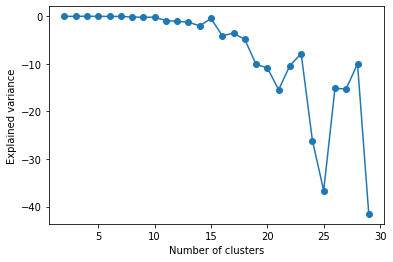

In [11]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import explained_variance_score

scaler = StandardScaler()

data_returns = data['close'].pct_change().dropna()
returns_data_scaled = scaler.fit_transform(np.array(data_returns).reshape(-1,1))

explained_variance = []
for i in range(2, 30):
    kmeans = KMeans(n_clusters=i, random_state=0)
    kmeans.fit(returns_data_scaled)
    explained_variance.append(explained_variance_score(returns_data_scaled, kmeans.predict(returns_data_scaled)))
  
plt.plot(range(2, 30), explained_variance, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Explained variance')
plt.show()

In [12]:
data_returns

timestamp
2018-01-09 10:00:00   -0.369962
2018-01-09 11:00:00    0.664387
2018-01-09 12:00:00   -0.177229
2018-01-09 13:00:00   -1.138569
2018-01-09 14:00:00   -7.722974
                         ...   
2023-01-30 14:00:00    0.044436
2023-01-30 15:00:00   -0.024950
2023-01-30 16:00:00   -0.004717
2023-01-30 17:00:00   -0.004281
2023-01-30 18:00:00   -0.004093
Name: close, Length: 43864, dtype: float64

In [13]:
data['close']

timestamp
2018-01-09 09:00:00    0.058192
2018-01-09 10:00:00    0.036663
2018-01-09 11:00:00    0.061022
2018-01-09 12:00:00    0.050207
2018-01-09 13:00:00   -0.006957
                         ...   
2023-01-30 14:00:00    0.377937
2023-01-30 15:00:00    0.368508
2023-01-30 16:00:00    0.366769
2023-01-30 17:00:00    0.365199
2023-01-30 18:00:00    0.363705
Name: close, Length: 43865, dtype: float64

In [ ]:
polynomial + isolation cluster du au fait que je n'ai pas winsor les xcas extremes

In [73]:
kmeans = KMeans(n_clusters=21, random_state=0)
clusters = kmeans.fit_predict(returns_data_scaled)
pd.DataFrame(clusters).value_counts()

0     34954
12      437
14      290
18       62
11       40
8        21
20       15
6         4
15        4
5         3
10        3
4         2
19        2
7         1
9         1
1         1
13        1
3         1
16        1
17        1
2         1
dtype: int64

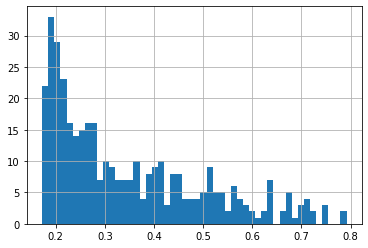

In [61]:
class_ret_df = pd.concat([data_returns,pd.DataFrame(clusters, index=data_returns.index, columns=['class'])],axis=1)
class_ret_df['prix'] = data['close'][data.index.isin(class_ret_df.index)]

for i in range(8):
    print(class_ret_df['close'][class_ret_df['class']==i].mean()*100)
    
class_ret_df['close'][class_ret_df['class']==7].hist(bins=50);

In [86]:
new_features = features.iloc[1:,:]
new_features["class"] = clusters

In [102]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(new_features.iloc[:,:1], new_features["class"], test_size = 0.2)

scaler = StandardScaler()
lgbm = LGBMClassifier(class_weight='balanced')

train_scaledd = scaler.fit_transform(X_train)
test_scaledd = scaler.transform(X_test)

lgbm.fit(train_scaledd, y_train)

predictions = lgbm.predict(test_scaledd)
predictions = pd.DataFrame(predictions)

accuracy_score on test dataset : 0.23824801227507322
              precision    recall  f1-score   support

           0       0.24      0.99      0.39      1702
           1       0.00      0.00      0.00        31
           2       0.00      0.00      0.00        25
           3       0.00      0.00      0.00        23
           4       0.00      0.00      0.00        39
           5       0.00      0.00      0.00        24
           6       0.00      0.00      0.00       110
           7       0.00      0.00      0.00        39
           8       0.00      0.00      0.00       388
           9       0.00      0.00      0.00        27
          10       0.00      0.00      0.00        47
          11       0.00      0.00      0.00       481
          12       0.19      0.01      0.03      1114
          13       0.00      0.00      0.00         0
          14       0.25      0.01      0.02      1809
          15       0.00      0.00      0.00        91
          16       0.00     

<AxesSubplot: >

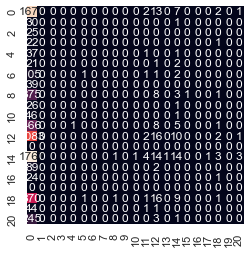

In [103]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
accuracy_test = accuracy_score(y_test, predictions)
print('accuracy_score on test dataset :', accuracy_test)
print(classification_report(predictions, y_test))
sns.set()
mat=confusion_matrix(y_test, predictions)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)

In [93]:
predictions.value_counts()

0     6095
12     281
18     205
11     200
17     142
19     113
1       43
5       35
20      28
15      27
dtype: int64

In [23]:
close_features = extract_features(test[["index", "Close"]], column_id='index')

Feature Extraction: 100%|██████████| 30/30 [00:13<00:00,  2.24it/s]


In [49]:
indexed_data = data.copy()
indexed_data['id'] = pd.Series(range(len(indexed_data)), index=data.index)

In [50]:
indexed_data = indexed_data.reset_index().iloc[:,1:].reset_index()

In [75]:
close_relevant_features = select_features(nanless_close_features.reset_index().iloc[1:,1:], indexed_data['Close'].diff().iloc[1:])

In [67]:
nanless_close_features = close_features.T.dropna().T.copy()

#au lieu de faire le dropna() faire du back fill et drop ceux avec trop de d onnées manquantes

In [ ]:
https://www.kaggle.com/code/patrickurbanke/feature-engineering-for-time-series

In [ ]:
polynomial elbow + kmeans test train
#differencier 1, 2, 3 fois
#n x n features